In [33]:
from datasets import load_dataset
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [34]:
dataset = load_dataset("BTX24/tekno21-brain-stroke-dataset-binary")
data = dataset['train']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.94k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/288M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/291M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7369 [00:00<?, ? examples/s]

In [36]:
image_paths = data['image']
labels = data['label']

In [38]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

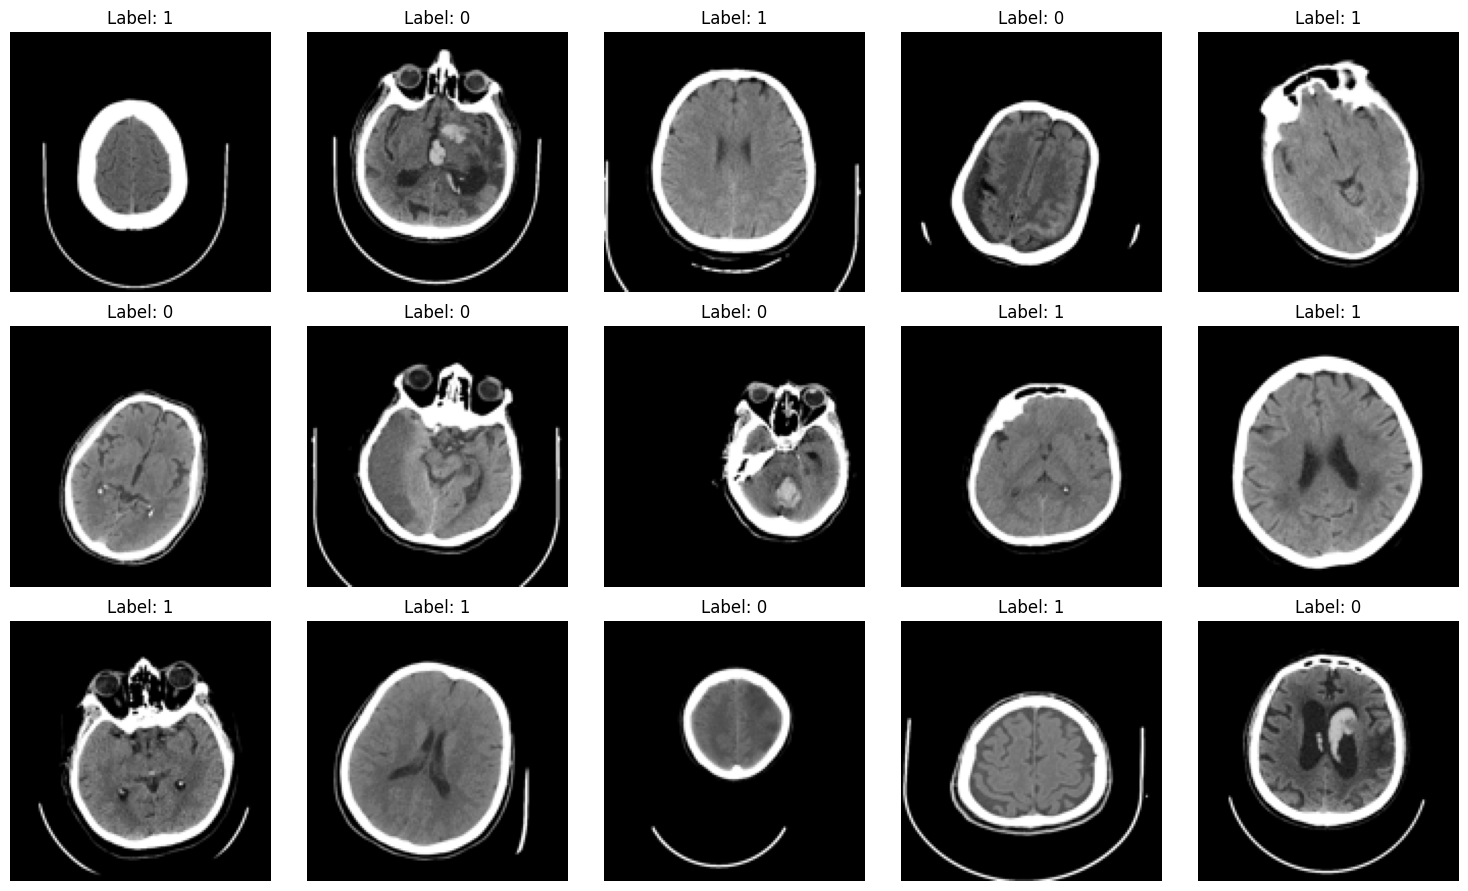

In [45]:
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i in range(15):
    row, col = divmod(i, 5)
    img = train_paths[i].convert("L").resize((128, 128))
    axs[row, col].imshow(img, cmap='gray')
    axs[row, col].set_title(f"Label: {train_labels[i]}")
    axs[row, col].axis('off')
plt.tight_layout()
plt.show()

In [52]:
class StrokeDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.images = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].convert("L").resize((128, 128))
        img = np.expand_dims(np.array(img) / 255.0, axis=0).astype(np.float32)
        label = self.labels[idx]
        if self.transform:
            img = self.transform(torch.from_numpy(img))
        else:
            img = torch.from_numpy(img)
        return img, label

transform = transforms.Compose([
    transforms.Normalize([0.5], [0.5])
])

In [53]:
train_ds = StrokeDataset(train_paths, train_labels, transform)
val_ds = StrokeDataset(val_paths, val_labels, transform)

In [54]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

In [55]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 32 * 32, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [56]:
device = torch.device("cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [59]:
for epoch in range(10):
    model.train()
    total_loss = 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

Epoch 1 | Loss: 0.0260
Epoch 2 | Loss: 0.0187
Epoch 3 | Loss: 0.0240
Epoch 4 | Loss: 0.0308
Epoch 5 | Loss: 0.0166
Epoch 6 | Loss: 0.0124
Epoch 7 | Loss: 0.0141
Epoch 8 | Loss: 0.0094
Epoch 9 | Loss: 0.0144
Epoch 10 | Loss: 0.0120


In [60]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, lbls in val_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        out = model(imgs)
        preds = torch.argmax(out, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

              precision    recall  f1-score   support

           0     0.9286    0.9450    0.9367       564
           1     0.9656    0.9549    0.9602       910

    accuracy                         0.9512      1474
   macro avg     0.9471    0.9500    0.9485      1474
weighted avg     0.9514    0.9512    0.9512      1474



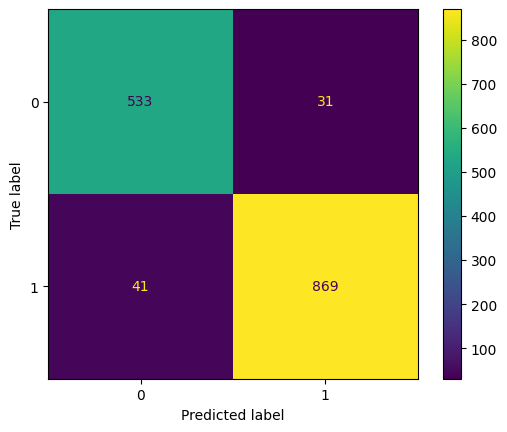

In [61]:
print(classification_report(all_labels, all_preds, digits=4))
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm).plot()
plt.show()